# Compositional analysis of the ACM cardiac leucocytes 6mpi dataset (Pkp2+Ttn) - myeloids - using `milopy`:

and the single cell best practices tutorial https://www.sc-best-practices.org/conditions/compositional.html#without-labeled-clusters:

- **Developed by**: Christian Eger
- **Modified by**: Alexandra Cirnu
- **Talavera-López Lab - Würzburg Institute for Systems Immunology - Faculty of Medicine - Julius Maximilian Universität Würzburg**
- **Created on**: 231207
- **Last modified**: 240403

#### Environment: milopy

In [1]:
import scanpy as sc
import pandas as pd
import pertpy as pt
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import scvi
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from scipy.sparse import csr_matrix
import muon as mu
from muon import atac as ac
from muon import prot

In [2]:
rpy2.robjects.numpy2ri.activate()

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R
library(edgeR)

R[write to console]: Loading required package: limma



In [5]:
sc.logging.print_versions()

-----
anndata     0.10.6
scanpy      1.9.8
-----
PIL                         10.2.0
absl                        NA
adjustText                  1.1.1
anyio                       NA
arrow                       1.3.0
arviz                       0.17.1
asttokens                   NA
attr                        23.2.0
attrs                       23.2.0
babel                       2.14.0
blitzgsea                   NA
brotli                      1.1.0
certifi                     2024.02.02
cffi                        1.16.0
chardet                     5.2.0
charset_normalizer          3.3.2
chex                        0.1.86
colorama                    0.4.6
comm                        0.2.2
contextlib2                 NA
custom_inherit              2.4.1
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.9.0
debugpy                     1.8.1
decorator                   5.1.1
decoupler                   1.6.0
defusedxml                  0.7.1
docr

#### Load in data

In [6]:
input = '/home/acirnu/data/ACM_cardiac_leuco/5_Leiden_clustering_and_annotation/ACM_myeloids_clustered_muon_ac240415.raw.h5mu'
mdata_data = mu.read_h5mu(input)
mdata_data

/home/acirnu/miniforge3/envs/milopy/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/acirnu/miniforge3/envs/milopy/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


MuData object with n_obs × n_vars = 34482 × 29477
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	34482 x 29378
      obs:	'cell_source', 'donor', 'n_counts', 'sample', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes_by_counts', 'total_counts', 'doublet_scores', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'batch', 'C_scANVI', 'leiden', 'classification'
      var:	'gene_ids', 'feature_types', 'mt', 'ribo'
      uns:	'C_scANVI_colors', 'classification_colors', 'dendrogram_leiden', 'leiden_colors', 'log1p', 'rank_genes_groups'
      obsm:	'X_pca', 'X_scANVI', 'X_scVI', 'X_umap'
      obsp:	'connectivities', 'distances'
    prot:	34482 x 99
      obs:	'library', 'batch'
      var:	'gene_ids', 'feature_types'
      uns:	'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts', 'log_norm'

In [7]:
adata = mdata_data.mod["rna"]
adata

AnnData object with n_obs × n_vars = 34482 × 29378
    obs: 'cell_source', 'donor', 'n_counts', 'sample', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes_by_counts', 'total_counts', 'doublet_scores', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'batch', 'C_scANVI', 'leiden', 'classification'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo'
    uns: 'C_scANVI_colors', 'classification_colors', 'dendrogram_leiden', 'leiden_colors', 'log1p', 'rank_genes_groups'
    obsm: 'X_pca', 'X_scANVI', 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

In [8]:
adata.obs["C_scANVI"].cat.categories

Index(['DC', 'DOCK4+MØ', 'LYVE1+MØ', 'Mast', 'Monocytes', 'MØ_general',
       'Neutrophils'],
      dtype='object')

### Subset adata to cell type of interest

In [9]:
adata = adata[adata.obs["C_scANVI"] == 'Mast'].copy()
adata

AnnData object with n_obs × n_vars = 108 × 29378
    obs: 'cell_source', 'donor', 'n_counts', 'sample', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes_by_counts', 'total_counts', 'doublet_scores', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'batch', 'C_scANVI', 'leiden', 'classification'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo'
    uns: 'C_scANVI_colors', 'classification_colors', 'dendrogram_leiden', 'leiden_colors', 'log1p', 'rank_genes_groups'
    obsm: 'X_pca', 'X_scANVI', 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

In [10]:
adata.obs

,cell_source,donor,n_counts,sample,seed_labels,condition,genotype,infection,library,model,...,percent_chrY,XIST-counts,S_score,G2M_score,_scvi_batch,_scvi_labels,batch,C_scANVI,leiden,classification
GTTACCCGTCACTACA-1-A1,AG_Gerull,Pkp2_Ctr_noninf_1,7030.0,Pkp2_Ctr_noninf_1,Mast,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,Pkp2,...,0.013858,0.0,-0.706877,0.106556,6,3,reference,Mast,13,Mast_13
TTGTTCACAGAGGCAT-1-A1,AG_Gerull,Pkp2_Ctr_noninf_2,7960.0,Pkp2_Ctr_noninf_2,Mast,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,Pkp2,...,0.024531,0.0,-0.276993,-0.259138,7,3,reference,Mast,13,Mast_13
CGCGTGAAGAACAAGG-1-A2,AG_Gerull,Pkp2_Ctr_noninf_2,5554.0,Pkp2_Ctr_noninf_2,Mast,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A2,Pkp2,...,0.052938,0.0,0.054423,-0.243975,7,3,reference,Mast,13,Mast_13
CGTTAGATCTGGCCGA-1-A2,AG_Gerull,Pkp2_Ctr_noninf_2,1393.0,Pkp2_Ctr_noninf_2,Mast,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A2,Pkp2,...,0.000000,0.0,-0.370550,-0.151676,7,3,reference,Mast,16,Mast_16
CTACAGAGTTGATCGT-1-A2,AG_Gerull,Pkp2_Ctr_noninf_2,5662.0,Pkp2_Ctr_noninf_2,Mast,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A2,Pkp2,...,0.034118,0.0,-0.376327,-0.358738,7,3,reference,Mast,13,Mast_13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCATGTTAGCCTCTCT-1-B2,AG_Gerull,Ttn_HetKO_MCMV_1,6395.0,Ttn_HetKO_MCMV_1,Unknown,Ttn_HetKO_MCMV,Ttn_HetKO,MCMV,B2,Ttn,...,0.031274,0.0,-0.277024,-0.554611,25,7,query,Mast,13,Mast_13
TCATTGTGTTCTCACC-1-B2,AG_Gerull,Ttn_HetKO_MCMV_1,5017.0,Ttn_HetKO_MCMV_1,Unknown,Ttn_HetKO_MCMV,Ttn_HetKO,MCMV,B2,Ttn,...,0.019932,0.0,-0.120600,-0.381516,25,7,query,Mast,13,Mast_13
TGAGGGAGTATGGTAA-1-B2,AG_Gerull,Ttn_HetKO_MCMV_1,1544.0,Ttn_HetKO_MCMV_1,Unknown,Ttn_HetKO_MCMV,Ttn_HetKO,MCMV,B2,Ttn,...,0.000000,0.0,-0.153690,0.061152,25,7,query,Mast,16,Mast_16
TGCGACGTCAGACCCG-1-B2,AG_Gerull,Ttn_Ctr_noninf_1,5651.0,Ttn_Ctr_noninf_1,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,Ttn,...,0.070784,0.0,-0.834657,-0.350331,23,7,query,Mast,16,Mast_16


#### Dimensionality reduction to assess whether we see a batch effect in this dataset

In [11]:
milo = pt.tl.Milo()
mdata = milo.load(adata)
mdata

MuData object with n_obs × n_vars = 108 × 29378
  2 modalities
    rna:	108 x 29378
      obs:	'cell_source', 'donor', 'n_counts', 'sample', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes_by_counts', 'total_counts', 'doublet_scores', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'batch', 'C_scANVI', 'leiden', 'classification'
      var:	'gene_ids', 'feature_types', 'mt', 'ribo'
      uns:	'C_scANVI_colors', 'classification_colors', 'dendrogram_leiden', 'leiden_colors', 'log1p', 'rank_genes_groups'
      obsm:	'X_pca', 'X_scANVI', 'X_scVI', 'X_umap'
      obsp:	'connectivities', 'distances'
    milo:	0 x 0

In [12]:
# use logcounts to calculate PCA and neighbors
adata.layers["counts"] = adata.X.copy()
adata.layers["logcounts"] = sc.pp.log1p(adata.layers["counts"]).copy()
adata.X = adata.layers["logcounts"].copy()

sc.pp.highly_variable_genes(
    adata, n_top_genes=3000, subset=False
)  # 3k genes as used by authors for clustering

sc.pp.neighbors(adata, n_neighbors=50, n_pcs=50, use_rep="X_scANVI")

/home/acirnu/miniforge3/envs/milopy/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


/home/acirnu/miniforge3/envs/milopy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/acirnu/miniforge3/envs/milopy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/acirnu/miniforge3/envs/milopy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(val

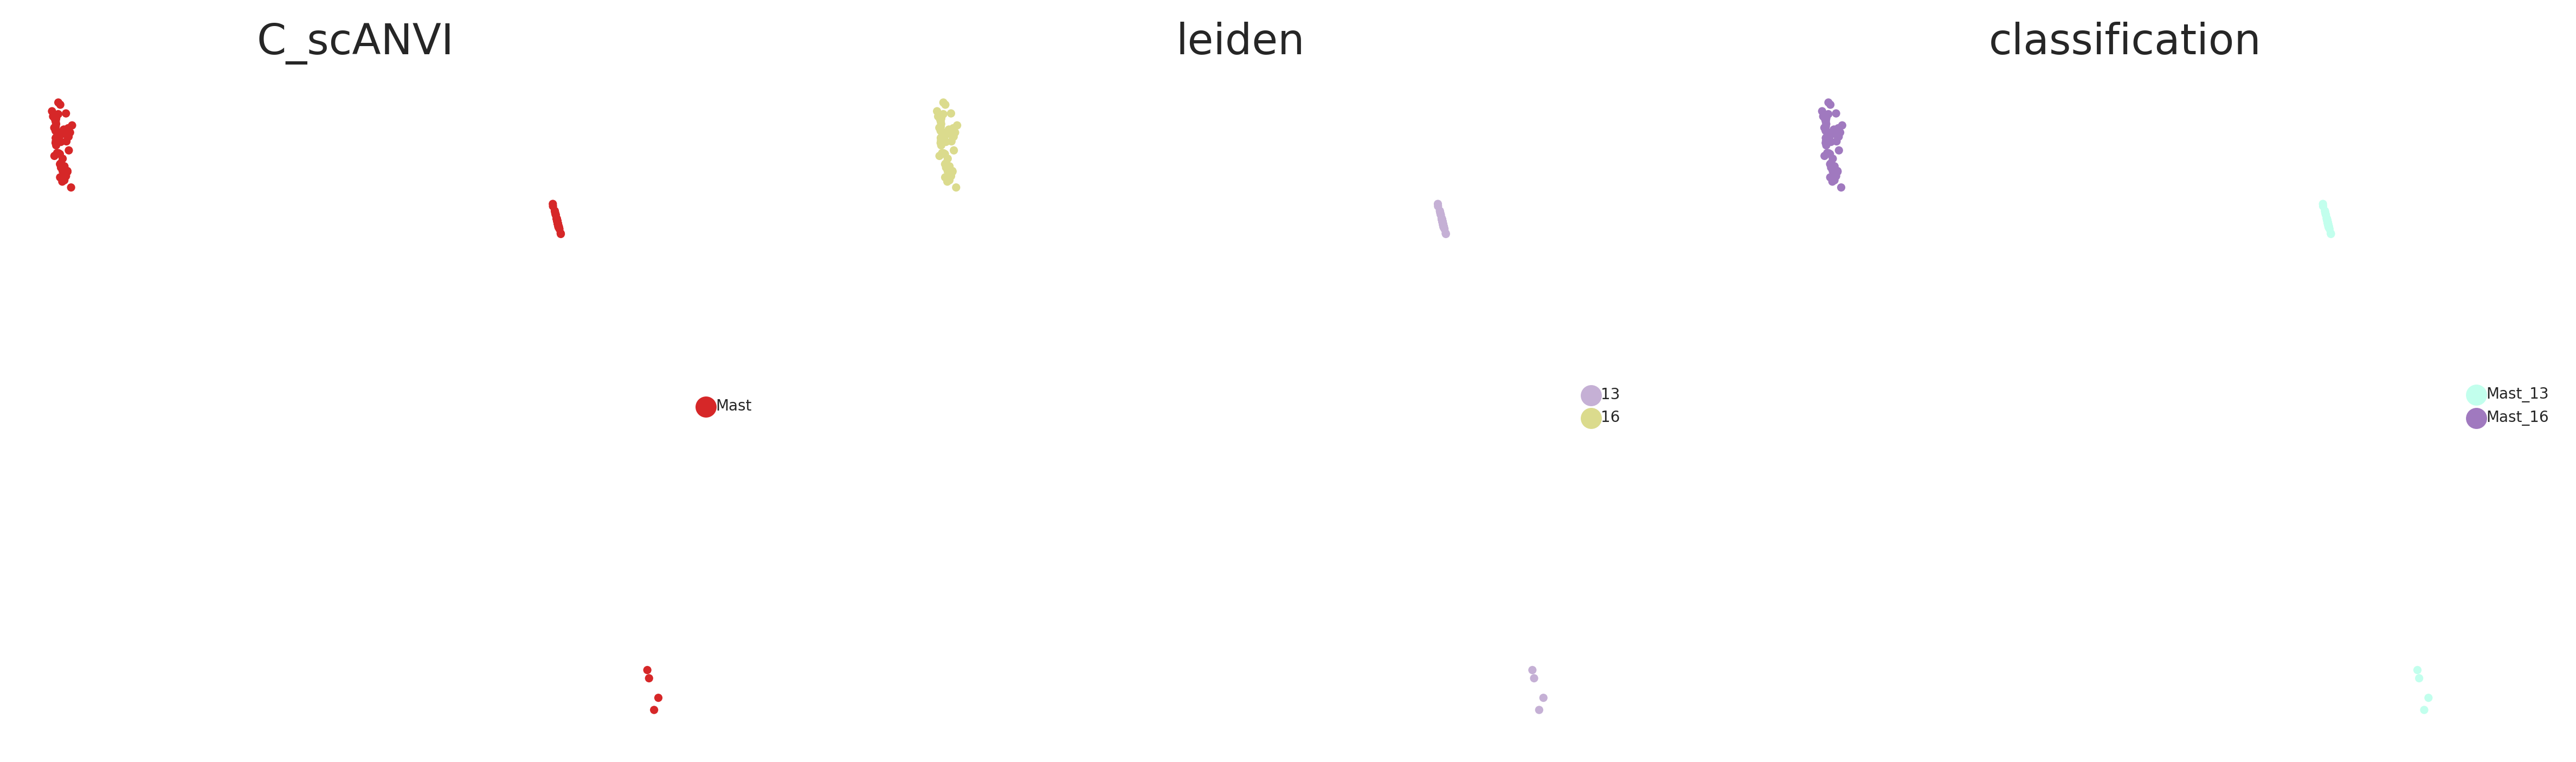

In [13]:
sc.settings.set_figure_params(dpi=200)
sc.pl.umap(adata, color=["C_scANVI", "leiden", "classification"], ncols=3, legend_loc="right margin", legend_fontsize= 5 , frameon=False, color_map="RdPu", size= 30)

#### Batch correction

In the single cell best practices tutorial there should be a batch correction step next. Skipped because batch correction already took place.

### Defining neighborhoods

In [14]:
milo.make_nhoods(mdata, prop=0.1)

/home/acirnu/miniforge3/envs/milopy/lib/python3.10/site-packages/pertpy/tools/_milo.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 5.52089739  5.14596844  5.40634584 10.74659538  5.41843843]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[adata.obs["nhood_ixs_refined"] == 1, "nhood_kth_distance"] = k_distances


In [15]:
adata.obsm["nhoods"]

<108x5 sparse matrix of type '<class 'numpy.float32'>'
	with 382 stored elements in Compressed Sparse Row format>

At this point we need to check the median number of cells in each neighbourhood, to make sure the neighbourhoods contain enough cells to detect differences between samples.

Text(0, 0.5, '# neighbouthoods')

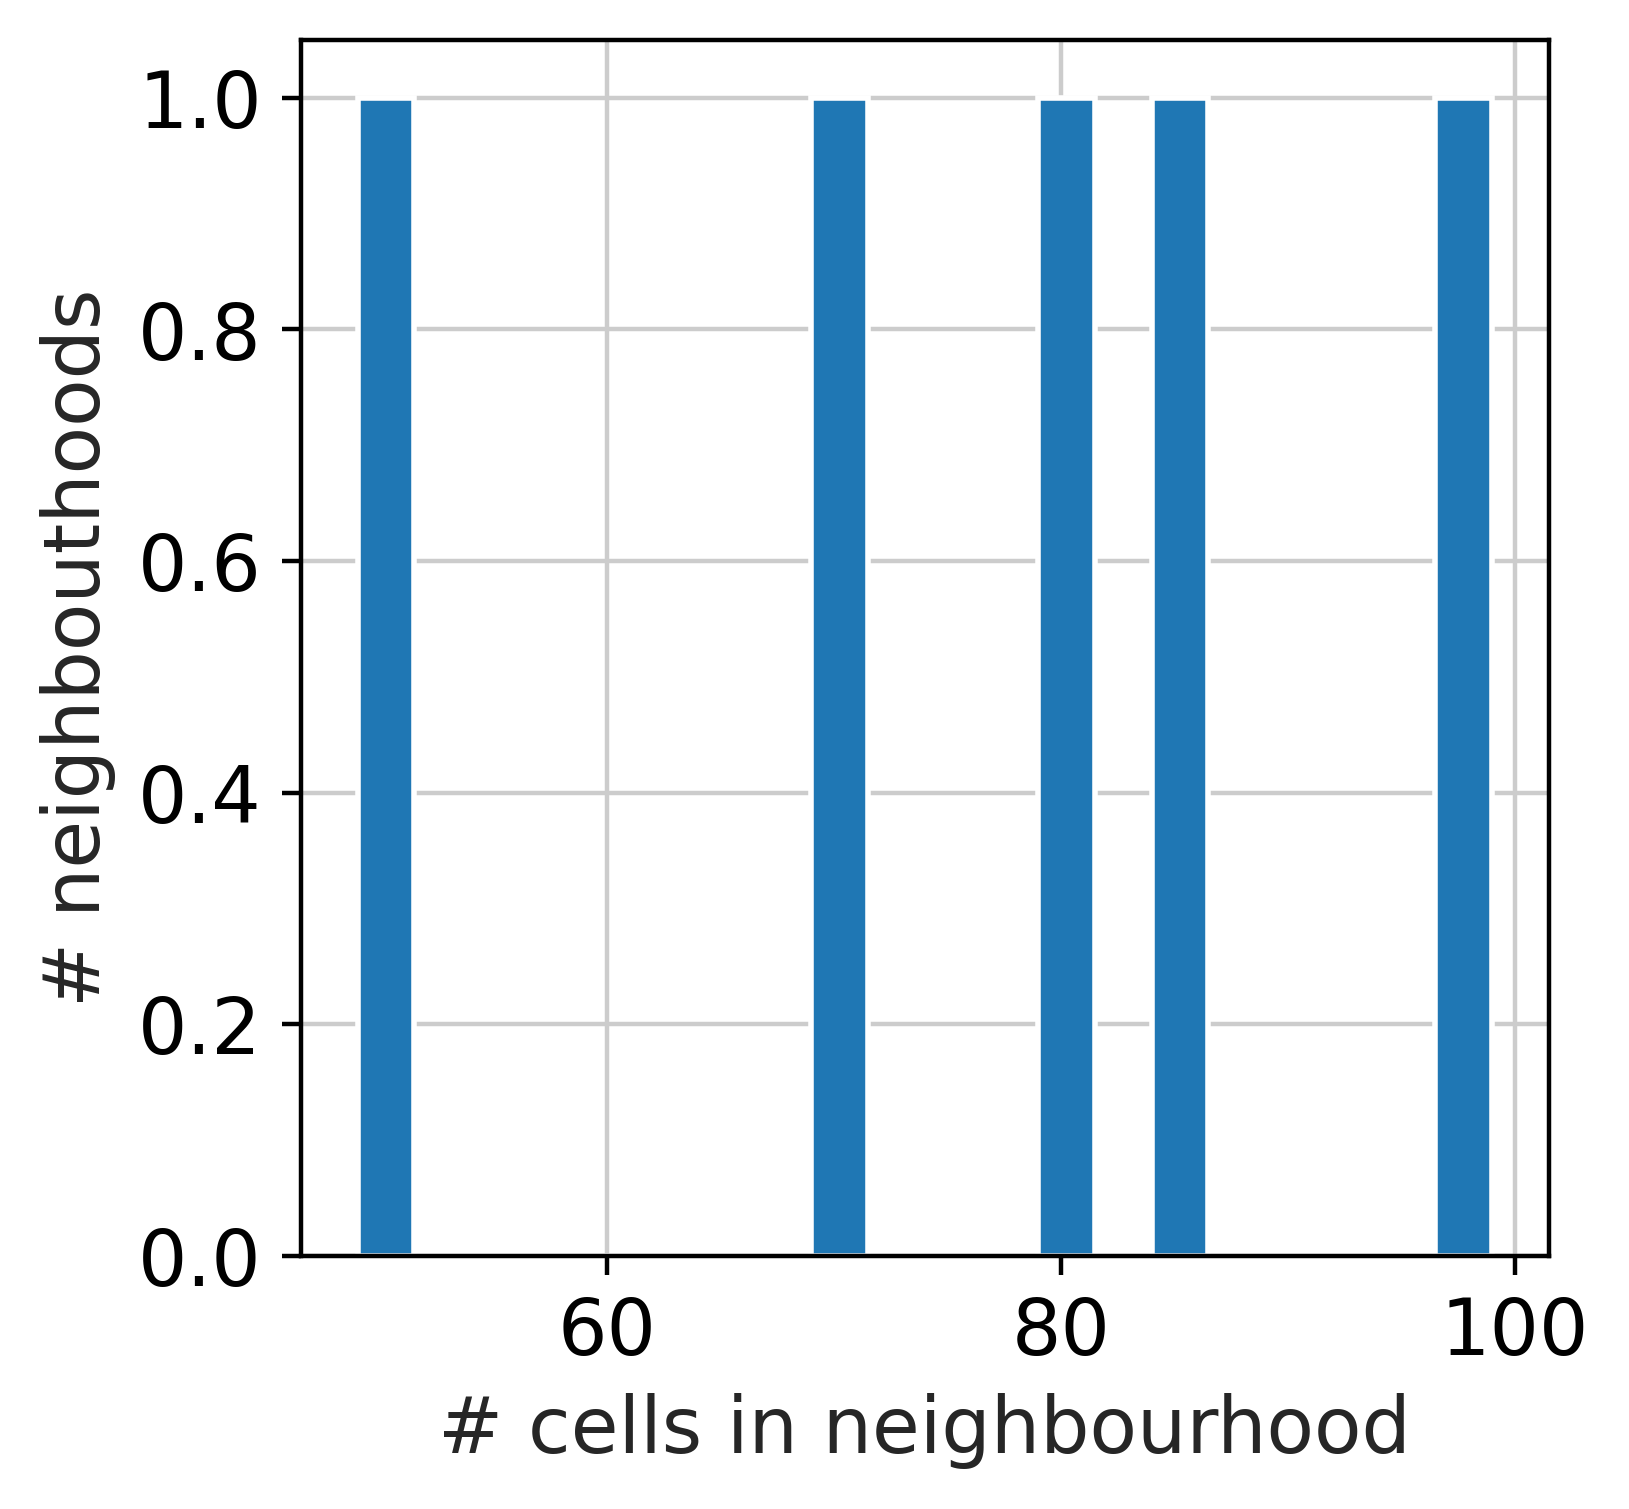

In [16]:
nhood_size = adata.obsm["nhoods"].toarray().sum(0)
plt.hist(nhood_size, bins=20)
plt.xlabel("# cells in neighbourhood")
plt.ylabel("# neighbouthoods")

In [17]:
np.median(nhood_size)

79.0

In [18]:
sc.pp.neighbors(adata, n_neighbors=50, use_rep="X_scANVI", key_added="milo")
milo.make_nhoods(mdata, neighbors_key="milo", prop=0.1)

/home/acirnu/miniforge3/envs/milopy/lib/python3.10/site-packages/pertpy/tools/_milo.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 5.52089739  5.14596844  5.40634584 10.74659538  5.41843843]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[adata.obs["nhood_ixs_refined"] == 1, "nhood_kth_distance"] = k_distances


Text(0, 0.5, '# neighbouthoods')

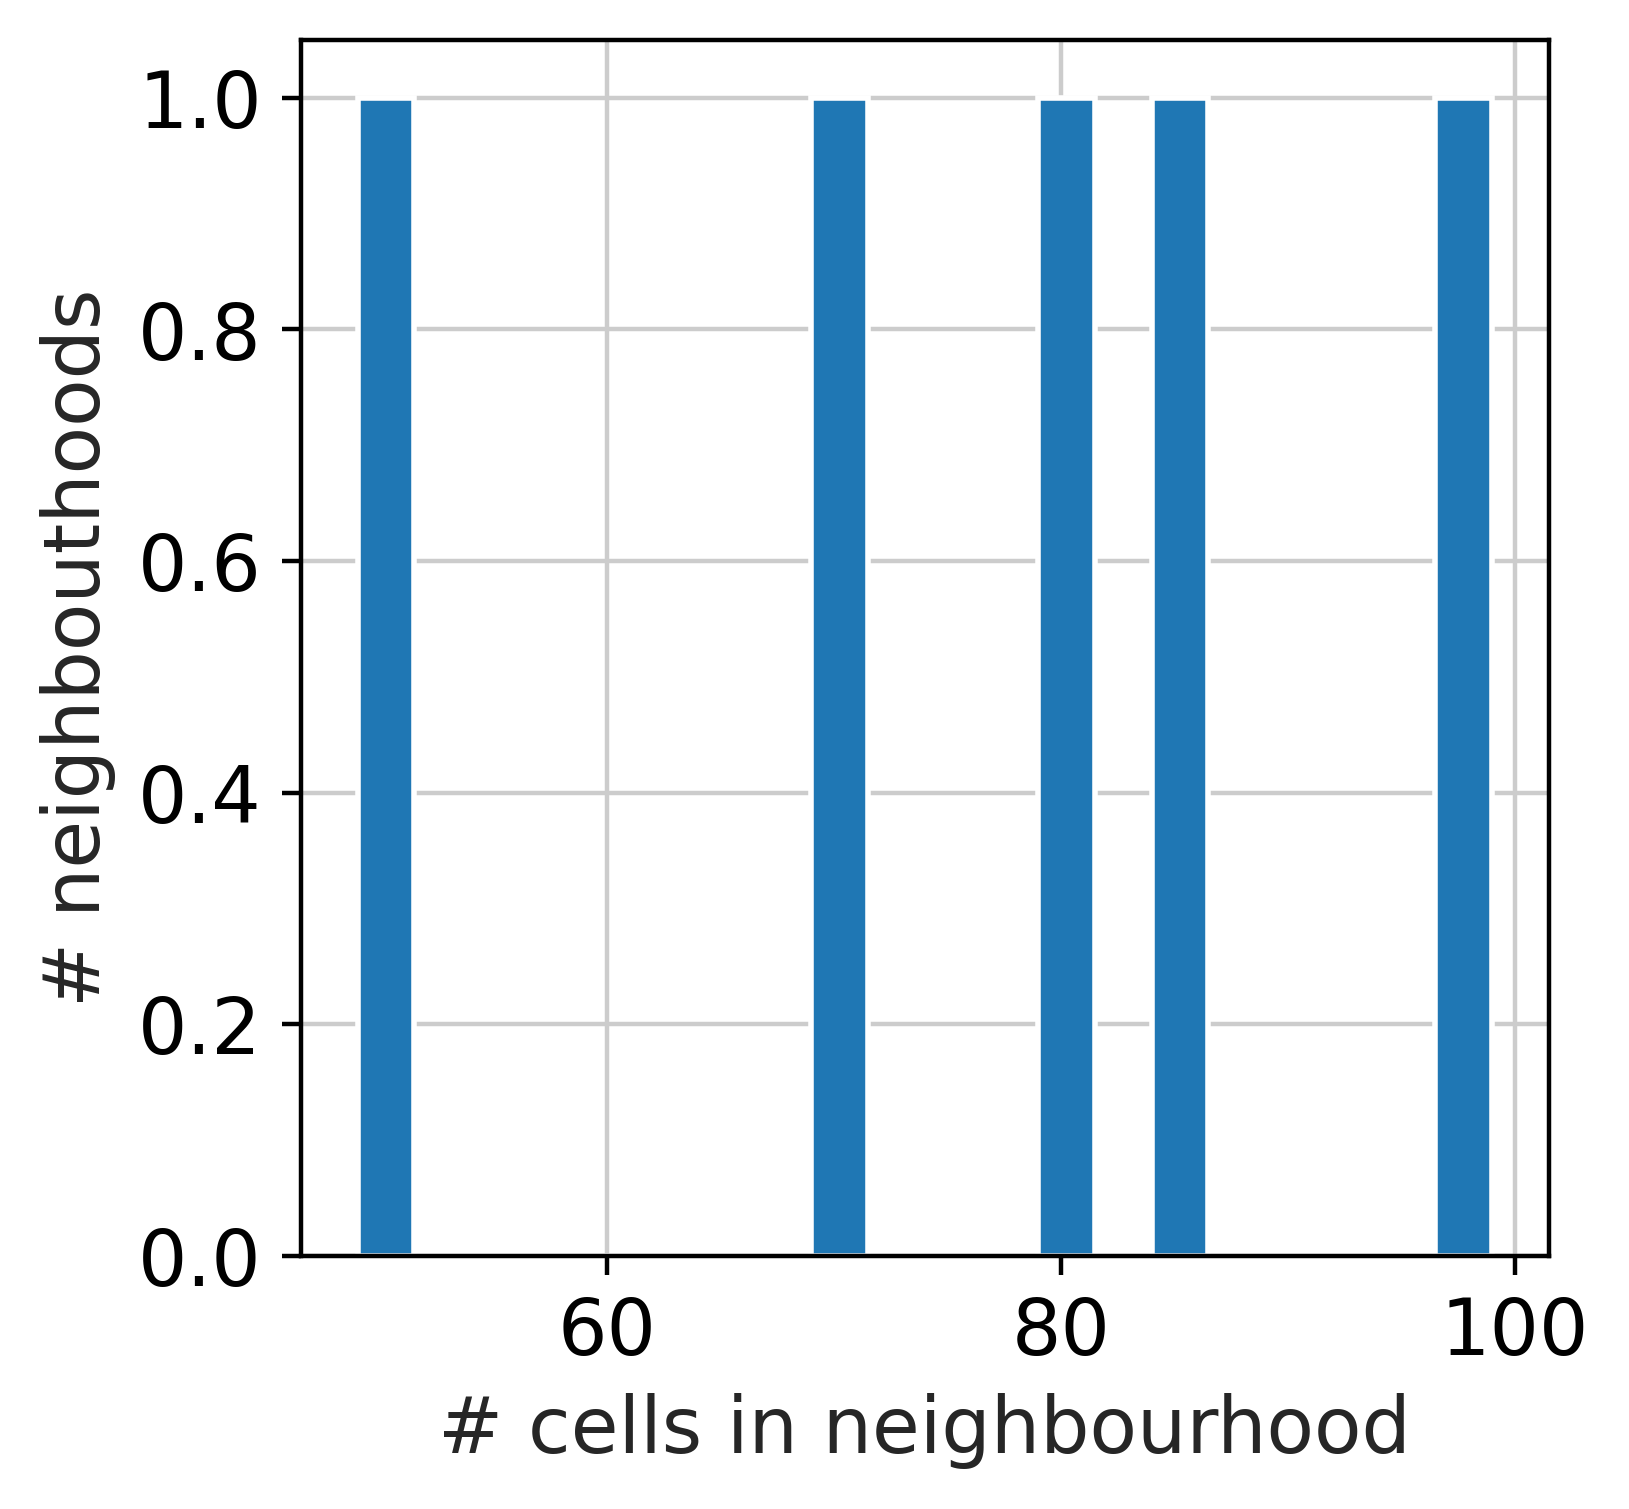

In [19]:
nhood_size = adata.obsm["nhoods"].toarray().sum(0)
plt.hist(nhood_size, bins=20)
plt.xlabel("# cells in neighbourhood")
plt.ylabel("# neighbouthoods")

In [20]:
np.median(nhood_size)

79.0

#### Count cells in neighborhood

In [21]:
adata.obs

,cell_source,donor,n_counts,sample,seed_labels,condition,genotype,infection,library,model,...,G2M_score,_scvi_batch,_scvi_labels,batch,C_scANVI,leiden,classification,nhood_ixs_random,nhood_ixs_refined,nhood_kth_distance
GTTACCCGTCACTACA-1-A1,AG_Gerull,Pkp2_Ctr_noninf_1,7030.0,Pkp2_Ctr_noninf_1,Mast,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,Pkp2,...,0.106556,6,3,reference,Mast,13,Mast_13,0,0,0.0
TTGTTCACAGAGGCAT-1-A1,AG_Gerull,Pkp2_Ctr_noninf_2,7960.0,Pkp2_Ctr_noninf_2,Mast,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,Pkp2,...,-0.259138,7,3,reference,Mast,13,Mast_13,0,0,0.0
CGCGTGAAGAACAAGG-1-A2,AG_Gerull,Pkp2_Ctr_noninf_2,5554.0,Pkp2_Ctr_noninf_2,Mast,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A2,Pkp2,...,-0.243975,7,3,reference,Mast,13,Mast_13,0,0,0.0
CGTTAGATCTGGCCGA-1-A2,AG_Gerull,Pkp2_Ctr_noninf_2,1393.0,Pkp2_Ctr_noninf_2,Mast,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A2,Pkp2,...,-0.151676,7,3,reference,Mast,16,Mast_16,0,0,0.0
CTACAGAGTTGATCGT-1-A2,AG_Gerull,Pkp2_Ctr_noninf_2,5662.0,Pkp2_Ctr_noninf_2,Mast,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A2,Pkp2,...,-0.358738,7,3,reference,Mast,13,Mast_13,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCATGTTAGCCTCTCT-1-B2,AG_Gerull,Ttn_HetKO_MCMV_1,6395.0,Ttn_HetKO_MCMV_1,Unknown,Ttn_HetKO_MCMV,Ttn_HetKO,MCMV,B2,Ttn,...,-0.554611,25,7,query,Mast,13,Mast_13,0,0,0.0
TCATTGTGTTCTCACC-1-B2,AG_Gerull,Ttn_HetKO_MCMV_1,5017.0,Ttn_HetKO_MCMV_1,Unknown,Ttn_HetKO_MCMV,Ttn_HetKO,MCMV,B2,Ttn,...,-0.381516,25,7,query,Mast,13,Mast_13,0,0,0.0
TGAGGGAGTATGGTAA-1-B2,AG_Gerull,Ttn_HetKO_MCMV_1,1544.0,Ttn_HetKO_MCMV_1,Unknown,Ttn_HetKO_MCMV,Ttn_HetKO,MCMV,B2,Ttn,...,0.061152,25,7,query,Mast,16,Mast_16,0,0,0.0
TGCGACGTCAGACCCG-1-B2,AG_Gerull,Ttn_Ctr_noninf_1,5651.0,Ttn_Ctr_noninf_1,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,Ttn,...,-0.350331,23,7,query,Mast,16,Mast_16,1,0,0.0


In [22]:
milo.count_nhoods(mdata, sample_col="donor")

/home/acirnu/miniforge3/envs/milopy/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


MuData object with n_obs × n_vars = 108 × 29378
  2 modalities
    rna:	108 x 29378
      obs:	'cell_source', 'donor', 'n_counts', 'sample', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes_by_counts', 'total_counts', 'doublet_scores', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'batch', 'C_scANVI', 'leiden', 'classification', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance'
      var:	'gene_ids', 'feature_types', 'mt', 'ribo', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'C_scANVI_colors', 'classification_colors', 'dendrogram_leiden', 'leiden_colors', 'log1p', 'rank_genes_groups', 'hvg', 'neighbors', 'nhood_neighbors_key', 'milo'
      obsm:	'X_pca', 'X_scANVI', 'X_scVI', 'X_umap', 'nhoods'
      layers:	'counts', 'logcounts'
      obsp:	'connectivities', 'distances', 'milo_distances', 'milo_connectivities'
    milo:	26 x 5
      var:	'index_cell', 'kth_distance'
      uns:	'sample_col'

Text(0, 0.5, 'Mean # cells per sample in nhood')

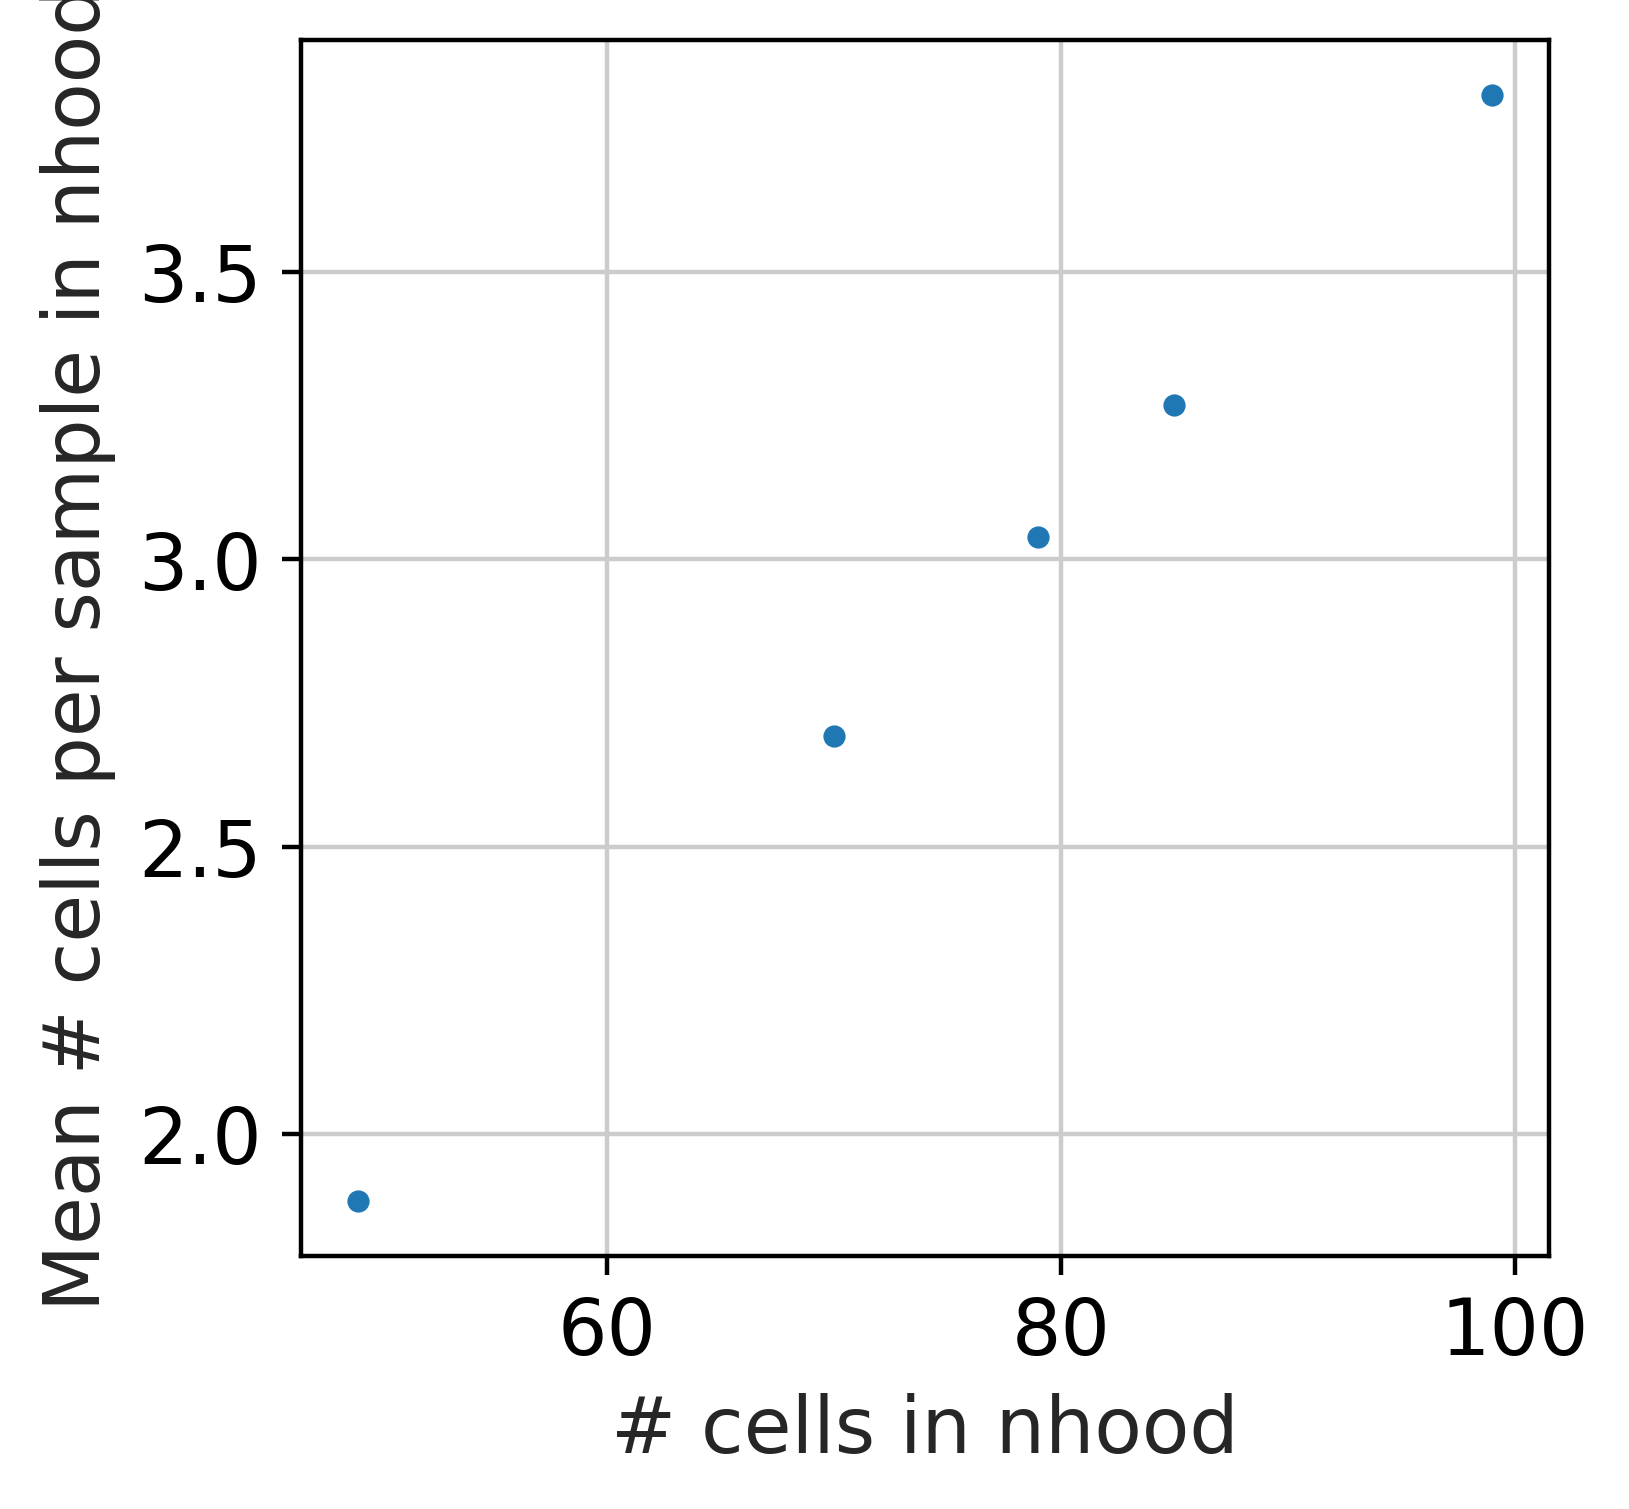

In [23]:
mean_n_cells = mdata["milo"].X.toarray().mean(0)
plt.plot(nhood_size, mean_n_cells, ".")
plt.xlabel("# cells in nhood")
plt.ylabel("Mean # cells per sample in nhood")

#### Run differential abundance test on neighborhoods

In [24]:
milo.da_nhoods(
    mdata, design="~genotype", model_contrasts="genotypePkp2_HetKO-genotypePkp2_Ctr"
)
milo_results_Pkp2_hetko = mdata["milo"].obs.copy()
milo_results_Pkp2_hetko

/home/acirnu/miniforge3/envs/milopy/lib/python3.10/site-packages/pertpy/tools/_milo.py:688: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvalues = pvalues[keep_nhoods][o]
/home/acirnu/miniforge3/envs/milopy/lib/python3.10/site-packages/pertpy/tools/_milo.py:689: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  w = w[keep_nhoods][o]


,genotype,donor
Pkp2_Ctr_MCMV_1,Pkp2_Ctr,Pkp2_Ctr_MCMV_1
Pkp2_Ctr_MCMV_2,Pkp2_Ctr,Pkp2_Ctr_MCMV_2
Pkp2_Ctr_MCMV_3,Pkp2_Ctr,Pkp2_Ctr_MCMV_3
Pkp2_Ctr_MCMV_4,Pkp2_Ctr,Pkp2_Ctr_MCMV_4
Pkp2_Ctr_MCMV_6,Pkp2_Ctr,Pkp2_Ctr_MCMV_6
Pkp2_Ctr_noninf_1,Pkp2_Ctr,Pkp2_Ctr_noninf_1
Pkp2_Ctr_noninf_2,Pkp2_Ctr,Pkp2_Ctr_noninf_2
Pkp2_Ctr_noninf_3,Pkp2_Ctr,Pkp2_Ctr_noninf_3
Pkp2_HetKO_MCMV_1,Pkp2_HetKO,Pkp2_HetKO_MCMV_1
Pkp2_HetKO_MCMV_2,Pkp2_HetKO,Pkp2_HetKO_MCMV_2


#### Data Diagnostics

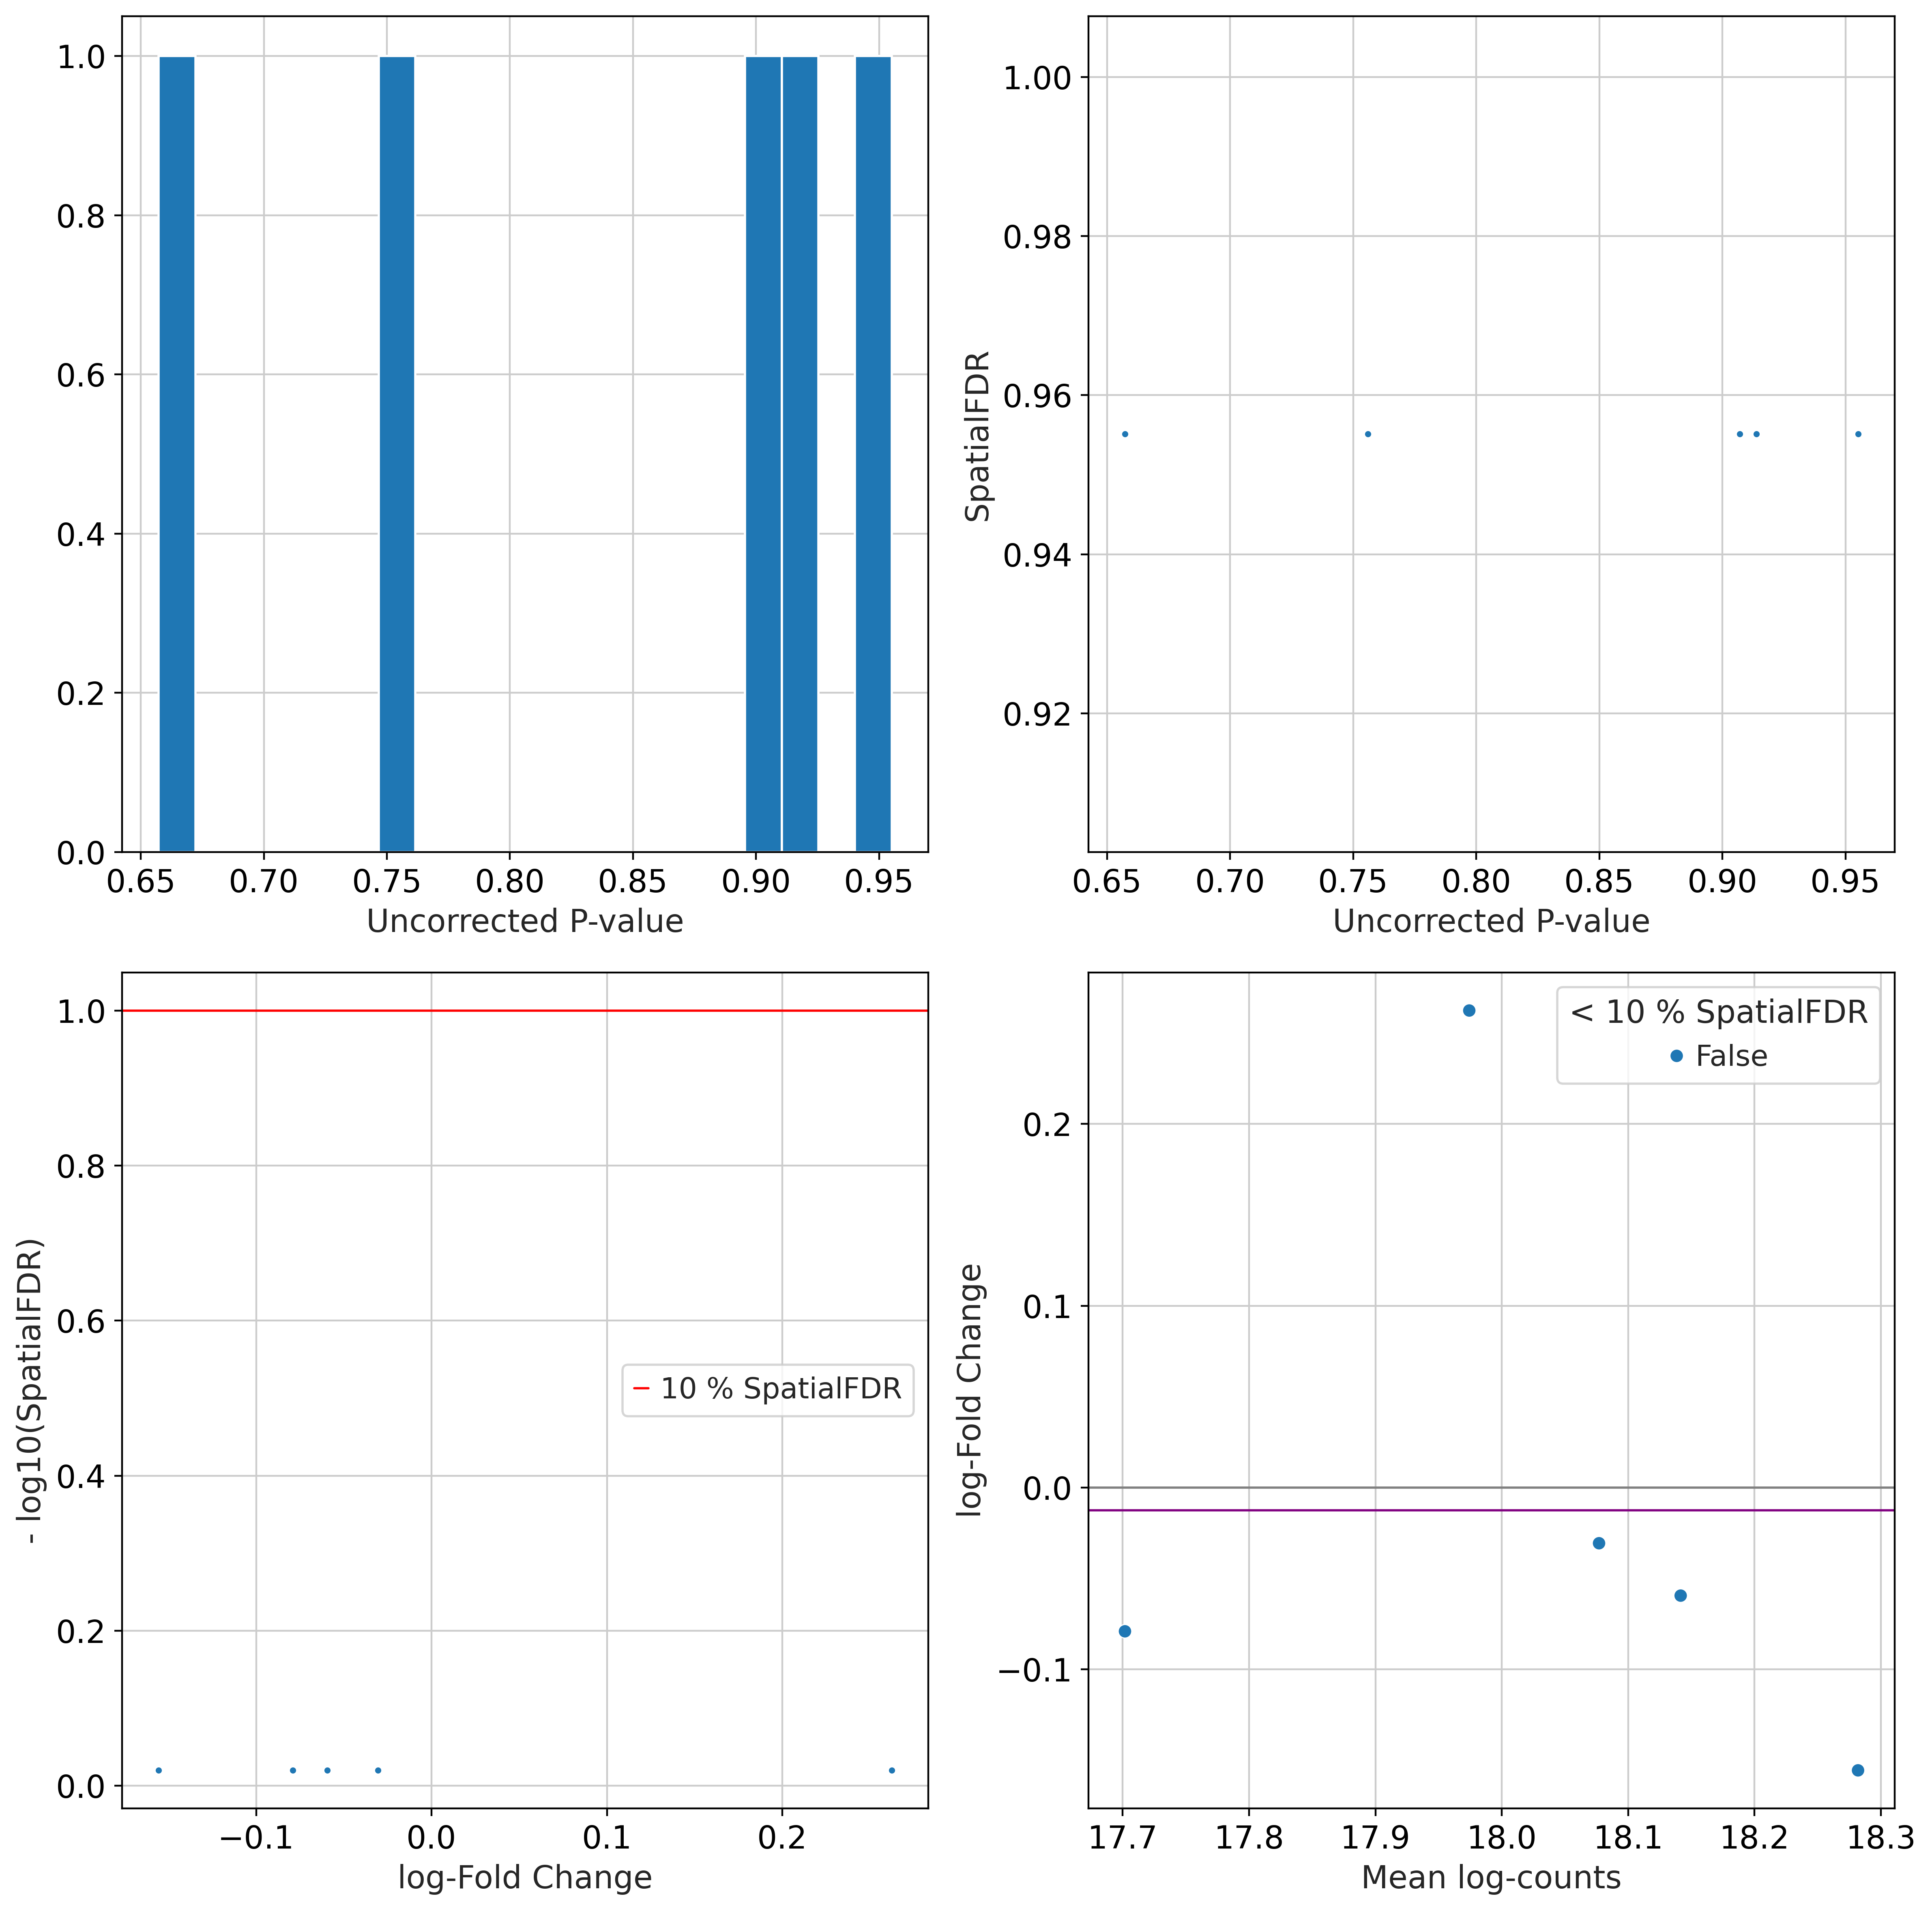

In [25]:
def plot_milo_diagnostics(mdata):
    alpha = 0.1  ## significance threshold

    with matplotlib.rc_context({"figure.figsize": [12, 12]}):

        ## Check P-value histogram
        plt.subplot(2, 2, 1)
        plt.hist(mdata["milo"].var["PValue"], bins=20)
        plt.xlabel("Uncorrected P-value")

        ## Visualize extent of multiple-testing correction
        plt.subplot(2, 2, 2)
        plt.scatter(
            mdata["milo"].var["PValue"],
            mdata["milo"].var["SpatialFDR"],
            s=3,
        )
        plt.xlabel("Uncorrected P-value")
        plt.ylabel("SpatialFDR")

        ## Visualize volcano plot
        plt.subplot(2, 2, 3)
        plt.scatter(
            mdata["milo"].var["logFC"],
            -np.log10(mdata["milo"].var["SpatialFDR"]),
            s=3,
        )
        plt.axhline(
            y=-np.log10(alpha),
            color="red",
            linewidth=1,
            label=f"{int(alpha*100)} % SpatialFDR",
        )
        plt.legend()
        plt.xlabel("log-Fold Change")
        plt.ylabel("- log10(SpatialFDR)")
        plt.tight_layout()

        ## Visualize MA plot
        df = mdata["milo"].var
        emp_null = df[df["SpatialFDR"] >= alpha]["logFC"].mean()
        df["Sig"] = df["SpatialFDR"] < alpha

        plt.subplot(2, 2, 4)
        sns.scatterplot(data=df, x="logCPM", y="logFC", hue="Sig")
        plt.axhline(y=0, color="grey", linewidth=1)
        plt.axhline(y=emp_null, color="purple", linewidth=1)
        plt.legend(title=f"< {int(alpha*100)} % SpatialFDR")
        plt.xlabel("Mean log-counts")
        plt.ylabel("log-Fold Change")
        plt.show()


plot_milo_diagnostics(mdata)

#### Plotting logfoldchange on cells

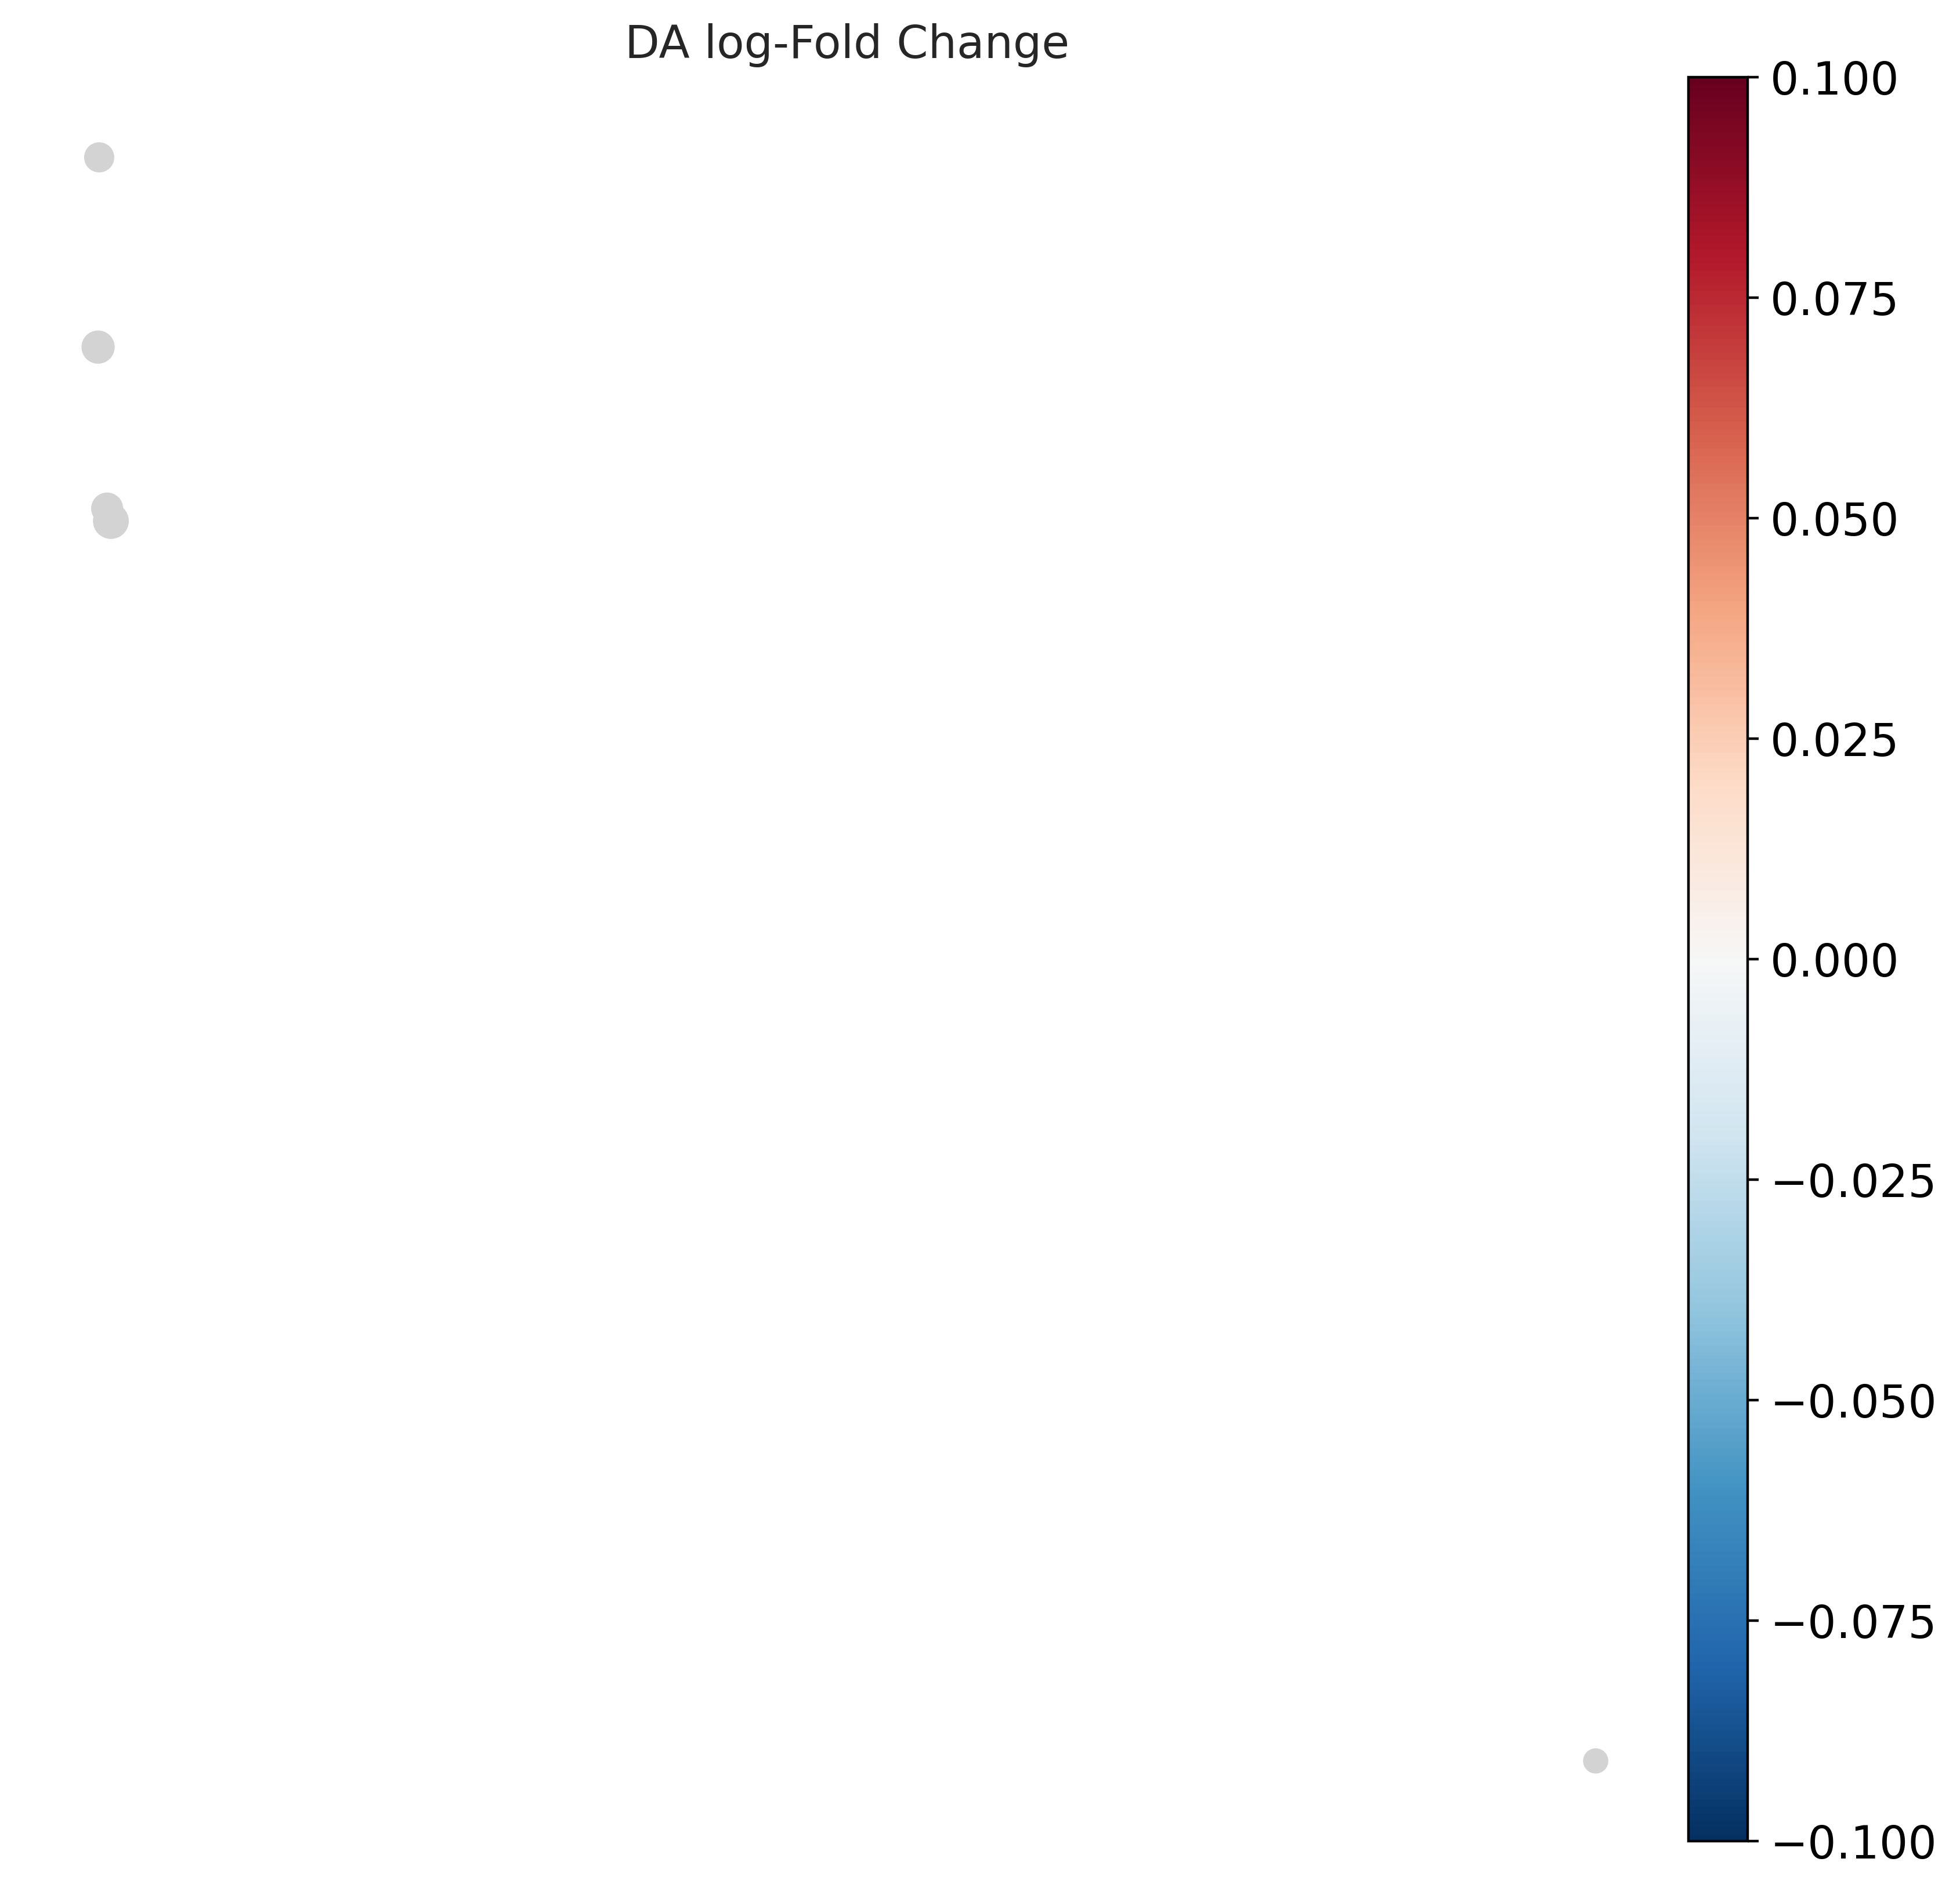

/home/acirnu/miniforge3/envs/milopy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/acirnu/miniforge3/envs/milopy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/acirnu/miniforge3/envs/milopy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(val

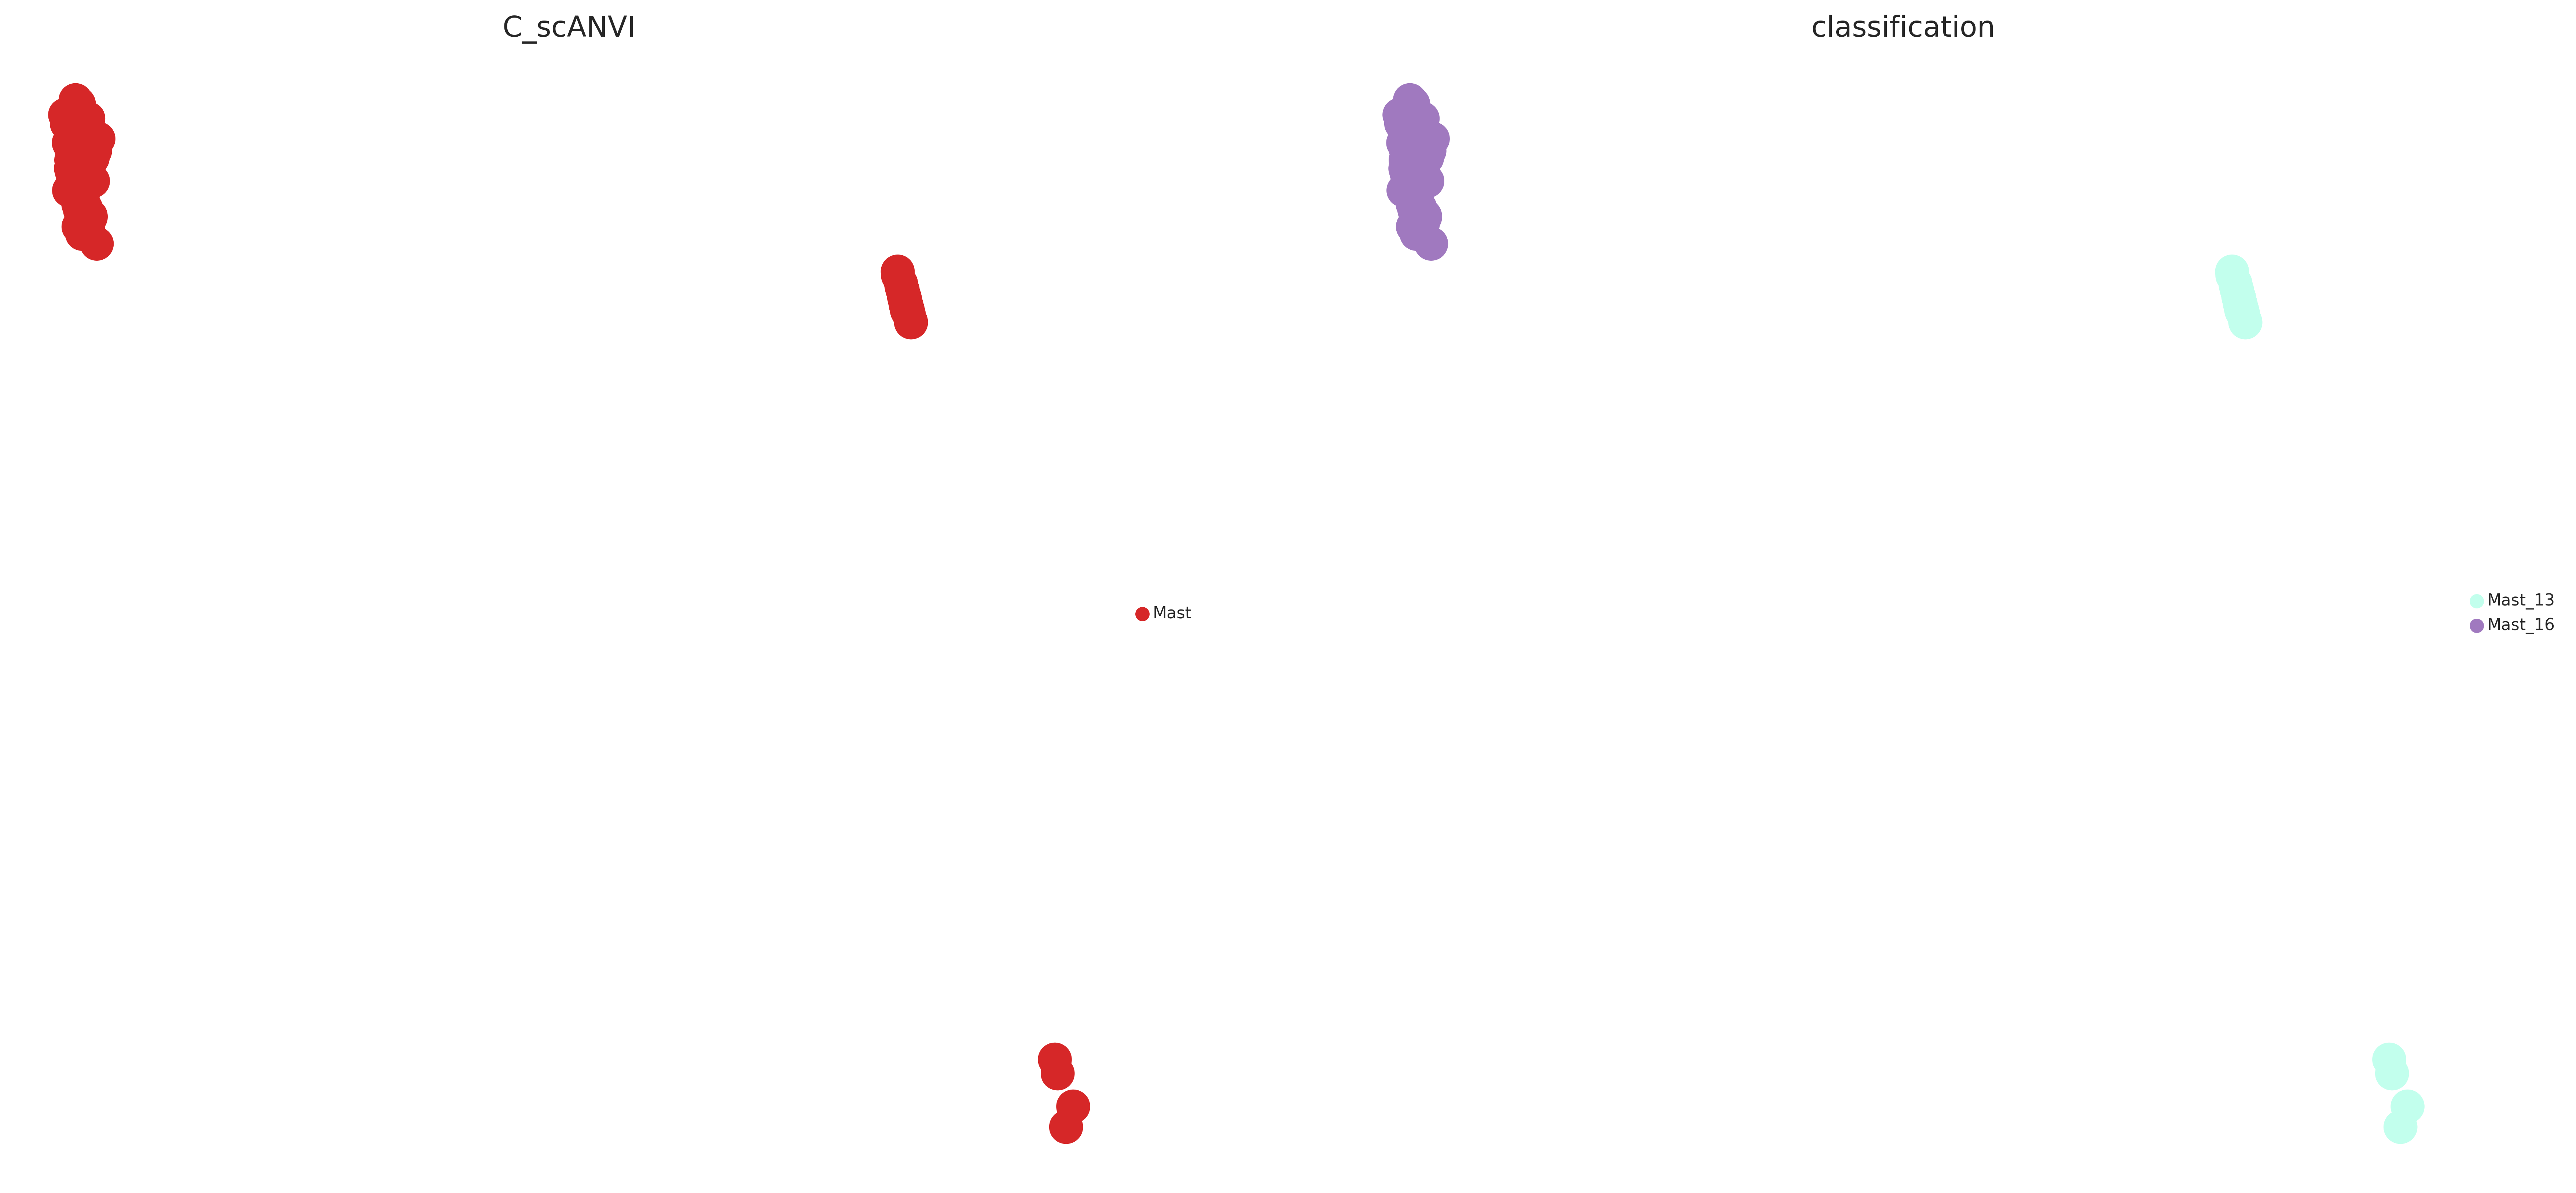

In [26]:
sc.settings.set_figure_params(dpi=200)
milo.build_nhood_graph(mdata)
with matplotlib.rc_context({"figure.figsize": [10, 10]}):
    milo.plot_nhood_graph(mdata, alpha=0.1, min_size=5, plot_edges=False)
    sc.pl.umap(mdata["rna"], color=["C_scANVI", "classification"], ncols= 2, legend_loc="right margin", legend_fontsize=8 , frameon= False, )

In [27]:
mdata["milo"]

AnnData object with n_obs × n_vars = 26 × 5
    obs: 'genotype', 'donor'
    var: 'index_cell', 'kth_distance', 'logFC', 'logCPM', 'F', 'PValue', 'FDR', 'SpatialFDR', 'Sig', 'Nhood_size'
    uns: 'sample_col', 'nhood'
    varm: 'X_milo_graph'
    varp: 'nhood_connectivities'

In [28]:
milo.annotate_nhoods(mdata, anno_col="classification")

# Define as mixed if fraction of cells in nhood with same label is lower than 0.75
#mdata["milo"].var["nhood_annotation"] = mdata["milo"].var["nhood_annotation"].cat.add_categories(['Mixed'])
#mdata["milo"].var.loc[mdata["milo"].var["nhood_annotation_frac"] < 0.75, "nhood_annotation"] = "Mixed"

In [29]:
mdata["milo"].var["nhood_annotation"].cat.categories

Index(['Mast_13', 'Mast_16'], dtype='object')

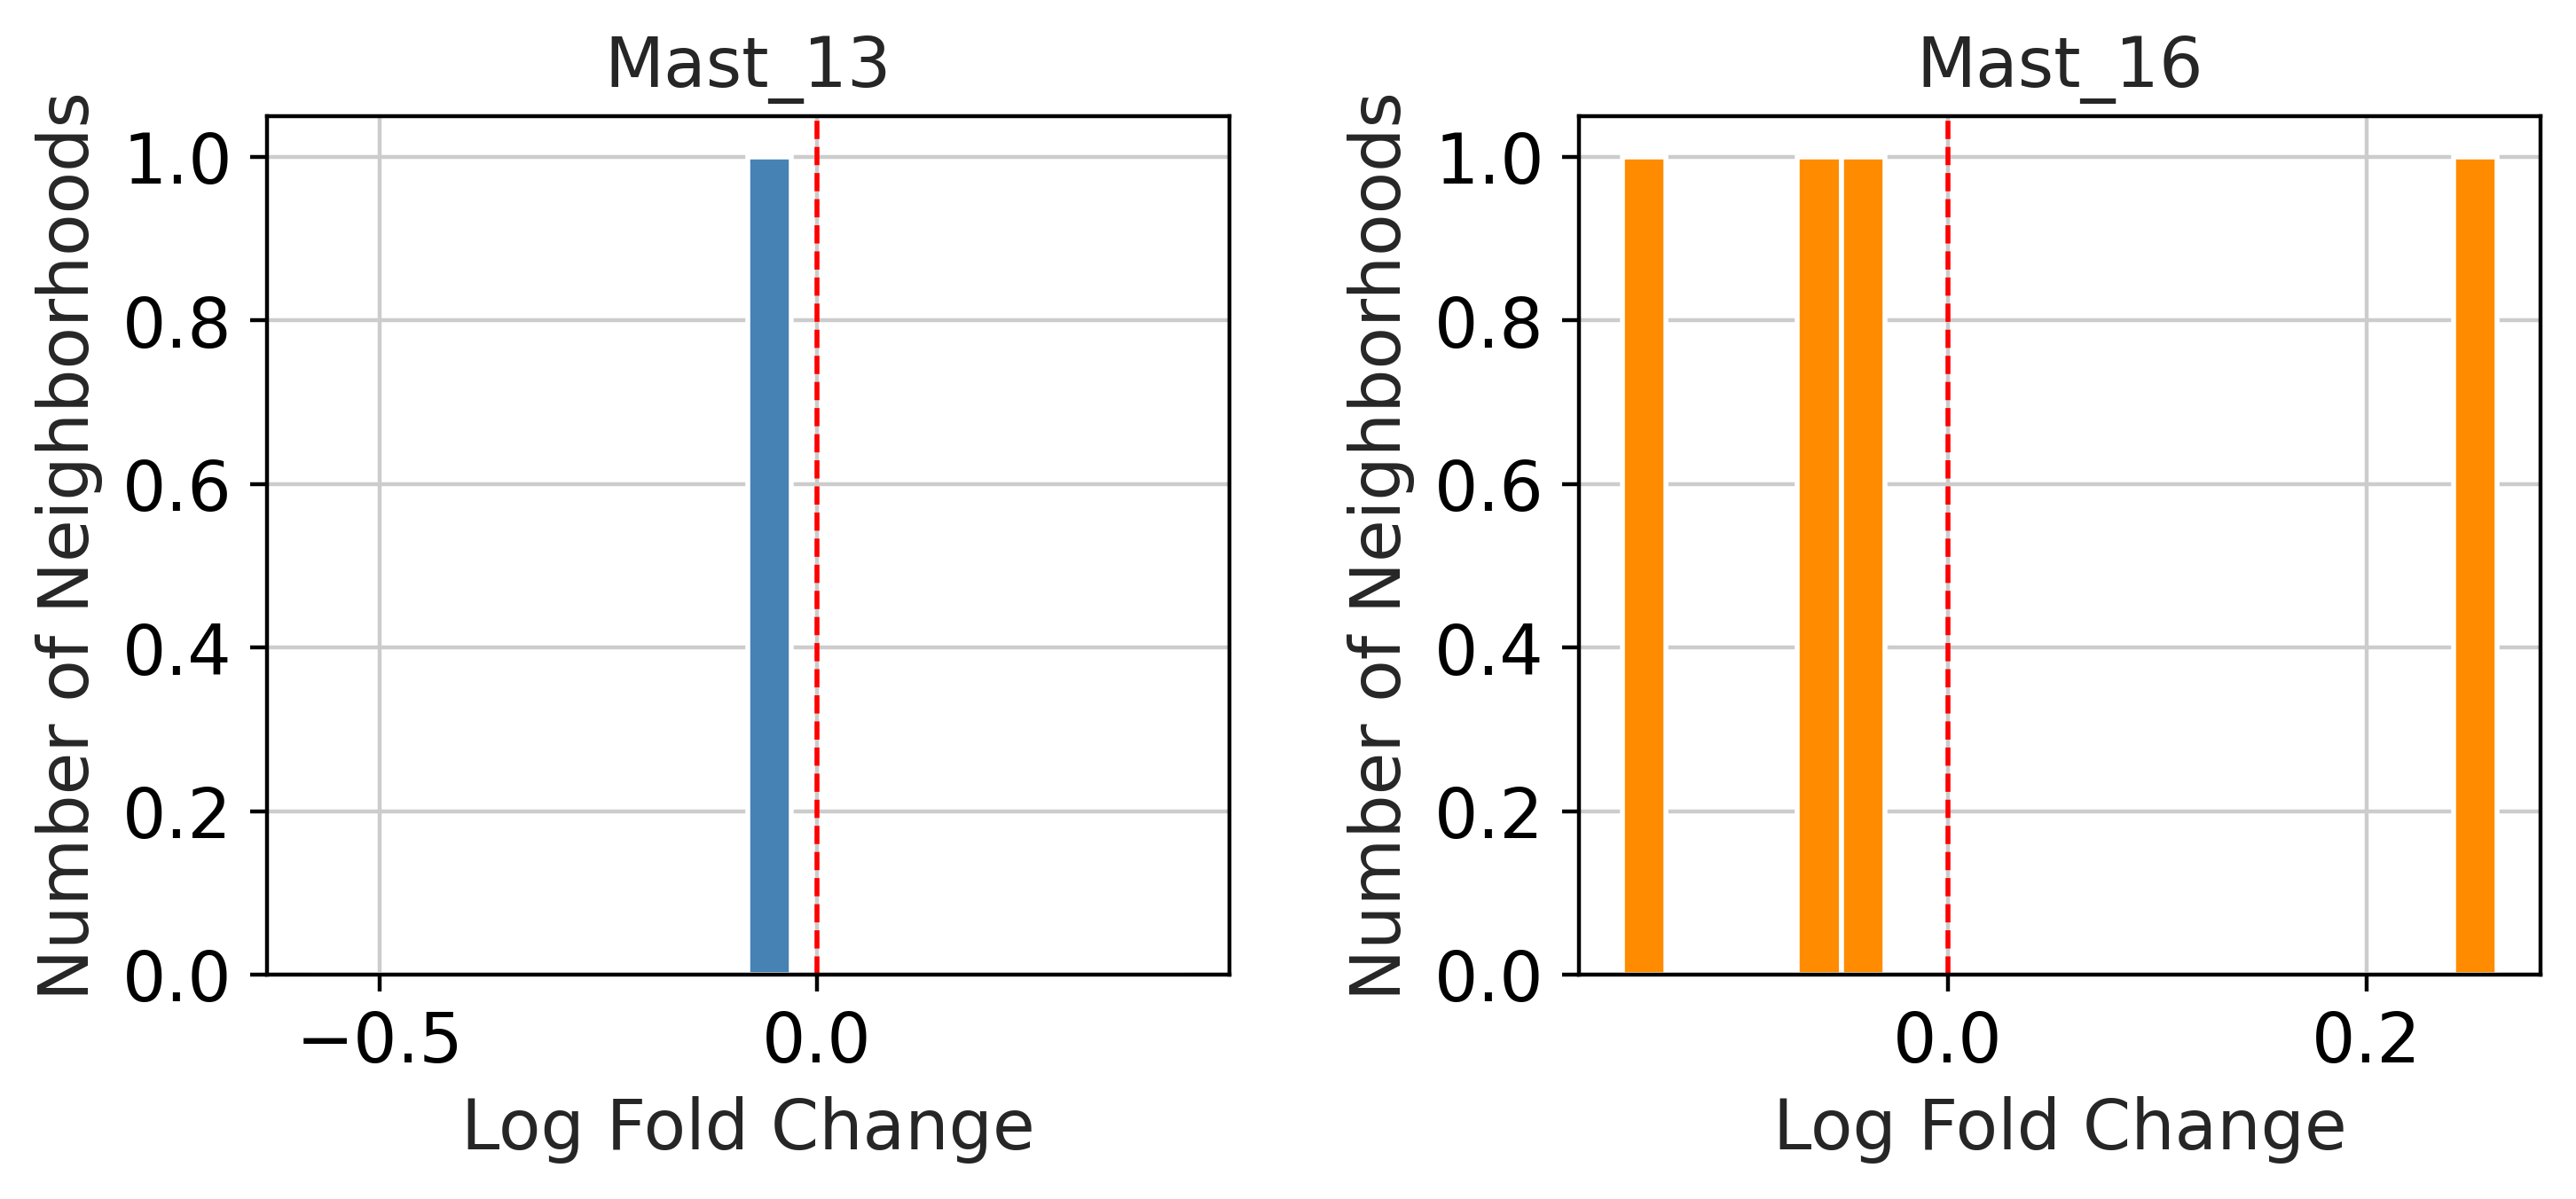

In [30]:
# Determine the number of categories
categories = mdata["milo"].var["nhood_annotation"].cat.categories
colors = ["steelblue", "darkorange", "forestgreen", "firebrick", "mediumpurple", "saddlebrown", "violet", "grey", "olive"]
while len(colors) < len(categories):
    colors += colors

# Calculate the grid size needed (assuming you want a 3x3 grid)
nrows = 19
ncols = 4
fig, axs = plt.subplots(nrows, ncols, sharey=False, sharex=False, tight_layout=False, figsize=(15,60))

# Loop through the categories and plot
for i, category in enumerate(categories):
    # Calculate the position of the current plot
    row = i // ncols
    col = i % ncols
    
    # Filter the data for the current category
    data = mdata["milo"].var[mdata["milo"].var["nhood_annotation"].isin([category])]["logFC"]
    
    # Plot the histogram
    axs[row, col].hist(data, bins=20, color=colors[i])
    axs[row, col].axvline(x=0, color='r', linewidth=1, linestyle='--')
    axs[row, col].set_xlabel("Log Fold Change")
    axs[row, col].set_ylabel("Number of Neighborhoods")
    axs[row, col].set_title(category)

# If there are fewer categories than subplots, you might want to hide the unused subplots
for j in range(i + 1, nrows * ncols):
    fig.delaxes(axs[j // ncols, j % ncols])

plt.show()

In [31]:
def significance_ratios(mdata_object):
    d = {"cell_compartments": [], "significance_ratio": []}
    for i in mdata_object["milo"].var["nhood_annotation"].unique():
        significant = 0
        insignificant = 0
        d["cell_compartments"].append(i)
        for j in mdata_object["milo"].var[mdata_object["milo"].var["nhood_annotation"].isin([i])]["Sig"]:
            if j == True:
                significant += 1
            else:
                insignificant += 1
        d["significance_ratio"].append(significant/(significant+insignificant))
    df = pd.DataFrame.from_dict(data=d)
    return df

/tmp/ipykernel_327729/1114529967.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=mdata["milo"].var, x="nhood_annotation", y="logFC", order=order, ax=axs[0], palette= "tab20")
/tmp/ipykernel_327729/1114529967.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90, ha="center")
/tmp/ipykernel_327729/1114529967.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=significance, x="cell_compartments", y="significance_ratio", order=order, ax=axs[1], palette= "tab20")
/tmp/ipykernel_327729/1114529967.py:15: UserWarning: set_ticklabels() should

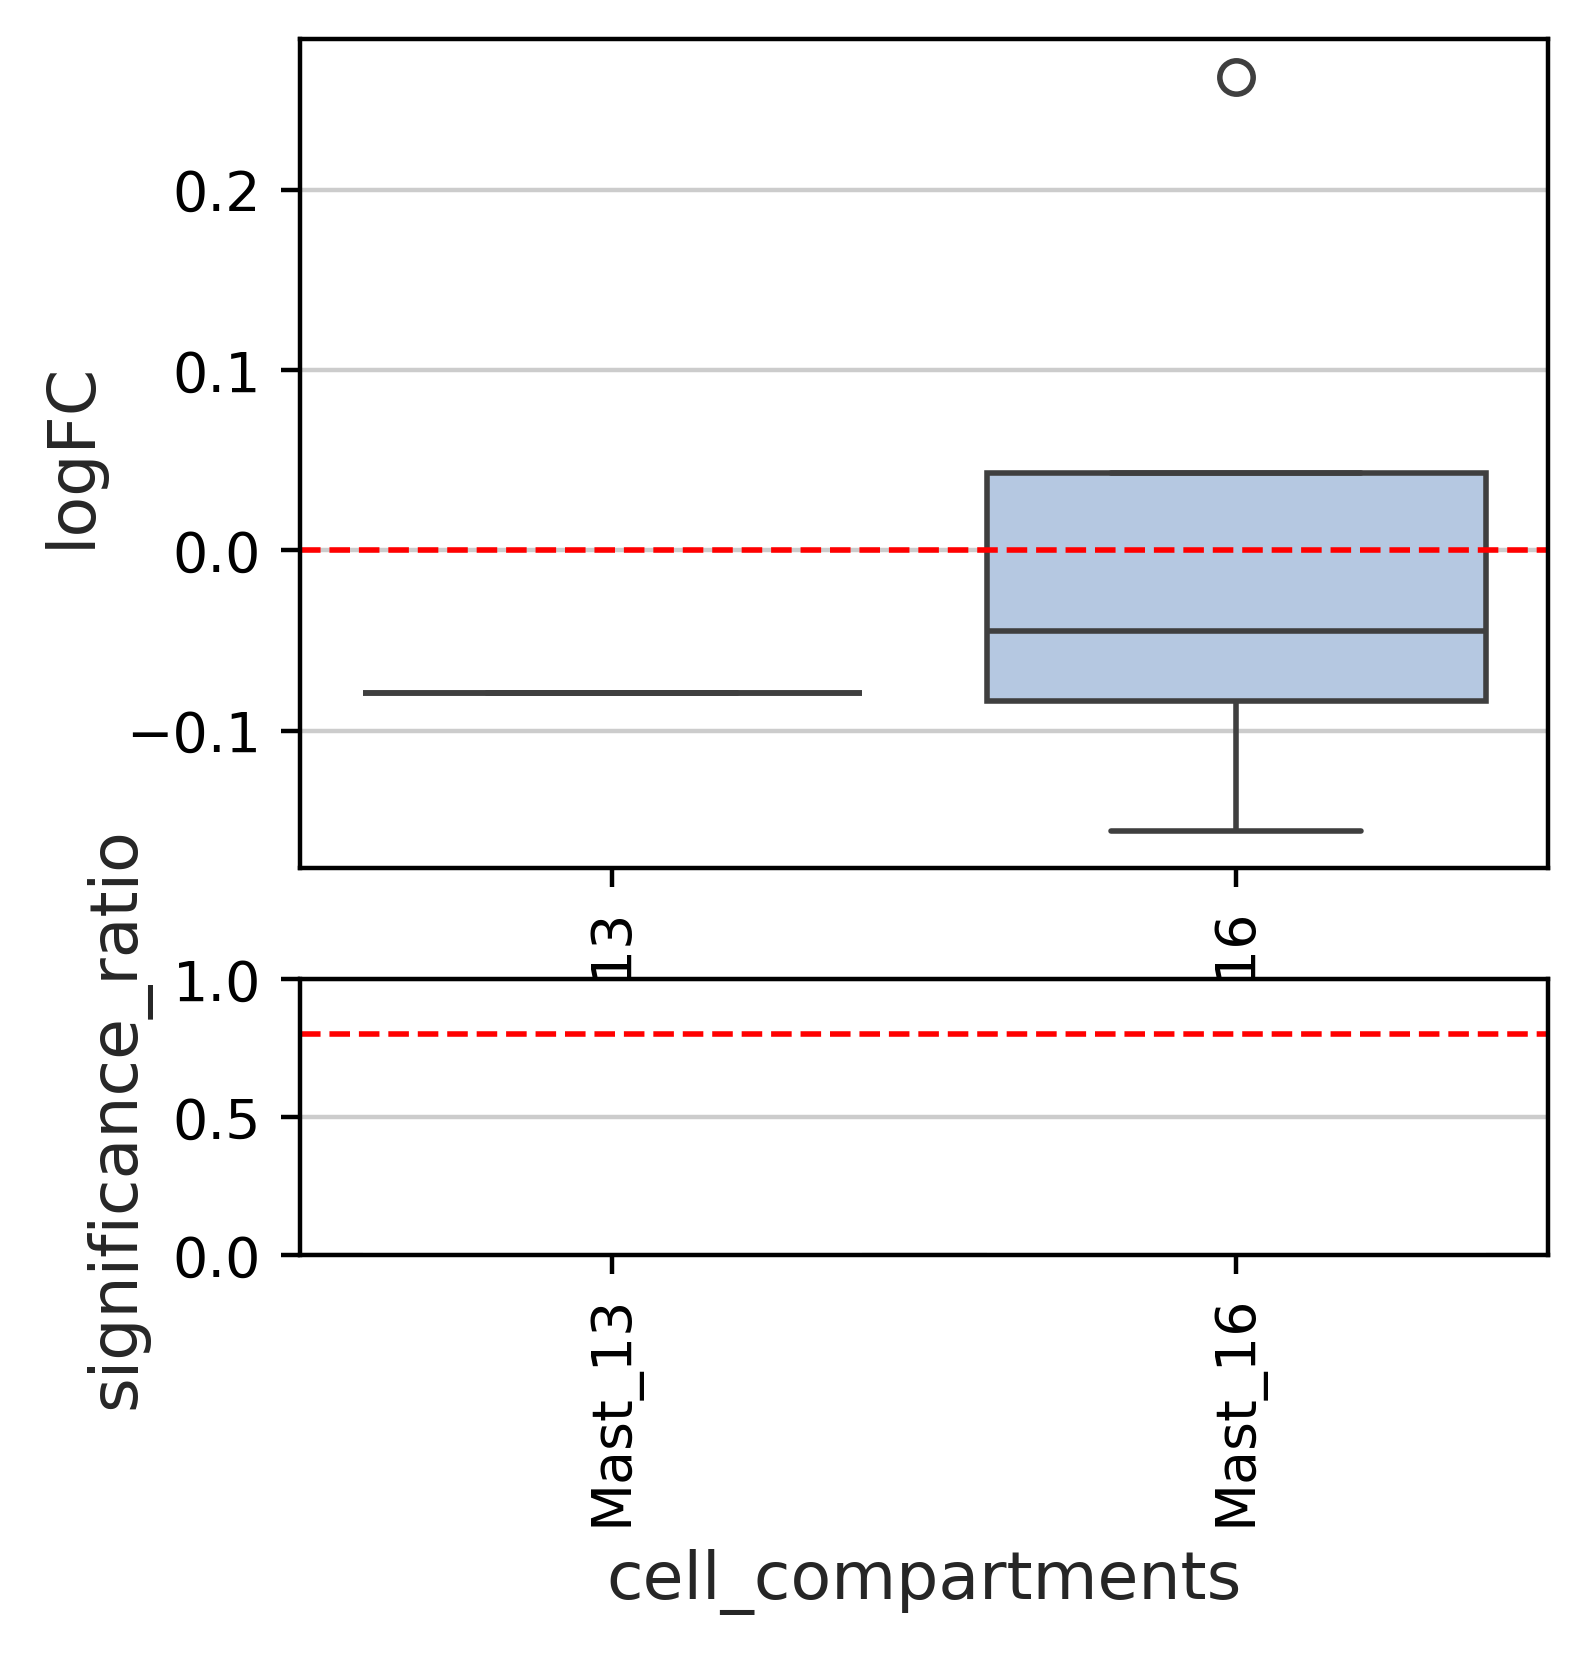

In [32]:
significance = significance_ratios(mdata)
order = ['Mast_13', 'Mast_16']
fig, axs = plt.subplots(2, figsize=(4,4), gridspec_kw={'height_ratios': [3, 1]})
sns.boxplot(data=mdata["milo"].var, x="nhood_annotation", y="logFC", order=order, ax=axs[0], palette= "tab20")
axs[0].axhline(y=0, color='r', linewidth=1, linestyle='--')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90, ha="center")
axs[0].set_xlabel("nhood_annotation", fontsize=12)
axs[0].set_ylabel("logFC", fontsize=12)
axs[0].tick_params(axis='x', labelsize=10)
axs[0].tick_params(axis='y', labelsize=10)

sns.barplot(data=significance, x="cell_compartments", y="significance_ratio", order=order, ax=axs[1], palette= "tab20")
plt.ylim(0, 1)
axs[1].axhline(y=0.8, color='r', linewidth=1, linestyle='--')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90, ha="center")
axs[1].set_xlabel("cell_compartments", fontsize=12)
axs[1].set_ylabel("significance_ratio", fontsize=12)
axs[1].tick_params(axis='x', labelsize=10)
axs[1].tick_params(axis='y', labelsize=10)